<a href="https://colab.research.google.com/github/Karlosicolombia/Synthethic-Training-Data-for-Sponswatch-AB/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds


tf.__version__


'2.11.0'

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import glob
import numpy as np
import os
import time
import imageio
import tensorflow as tf
from PIL import Image
import keras
import tensorflow.python.keras.backend as K
from tensorflow.keras import initializers
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, BatchNormalization, LeakyReLU, Dropout, Flatten, Reshape, ReLU

In [4]:





directory ='/content/drive/MyDrive/Adidas'

train_images = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode=None,
    class_names= None,
    color_mode='rgb',
    batch_size=4,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,

)







Found 230 files belonging to 1 classes.


In [5]:
train_dataset = [] 

for image in tfds.as_numpy(train_images):
  train_dataset.append(image)


train_dataset = tf.ragged.constant(train_dataset)

train_dataset = ((train_dataset-127.5)/127.5) #Normalize the tensor
train_dataset = tf.reshape(train_dataset,[-1, 128, 128, 3])
#train_dataset = np.expand_dims(train_dataset, axis=0)
train_dataset = train_dataset[None,:,:,:]


In [50]:
#Set appropriate buffer and batchsizes. 
print(train_dataset.shape)

BUFFER_SIZE = train_dataset.shape[1]
BATCH_SIZE = 128


(1, 230, 128, 128, 3)


In [7]:
def generator_model():
  model = Sequential()
  model.add(Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Reshape((8,8,256), input_shape=(8*8*256,)))

  model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())
      
  model.add(Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  #model.summary()
  return model

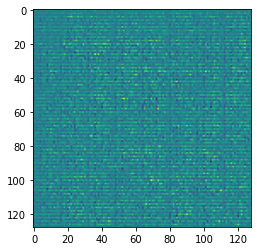

In [8]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generator_image = generator(noise, training = False)
plt.imshow(generator_image[0, :, :, 0])


In [9]:
def discriminator_model():
  model = Sequential()
  model.add(Conv2D(32, 5, strides=(2,2), padding='same', input_shape=(128,128,3)))
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(1))
    
  #model.summary()
  return model

In [10]:
discriminator = discriminator_model()
suspect = discriminator(generator_image)
suspect

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-7.170733e-05]], dtype=float32)>

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    print(total_loss)
    return total_loss

    

In [13]:
def reset_states(model):
  for ix, layer in enumerate(model.layers):
    if hasattr(model.layers[ix], 'kernel_initializer') and \
            hasattr(model.layers[ix], 'bias_initializer'):
        weight_initializer = model.layers[ix].kernel_initializer
     

        old_weights = model.layers[ix].get_weights()
        old_weights = tf.convert_to_tensor(old_weights)

        model.layers[ix].set_weights(
            weight_initializer(shape=old_weights.shape))
   
reset_states(generator)


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
def layer_weights(self):
  for layer in self.layers:
    a = layer.get_weights()
  

#layer_weights(discriminator)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:

EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  
  fig = plt.figure(figsize=(15,7))
  for i in range(predictions.shape[0]):
      preds = predictions[i,:,:,:]
      preds = np.array(preds)
      preds = (preds * 127.5) + 127.5
      plt.subplot(2, 5, i+1)
      p = (preds).astype(np.uint8)
      plt.imshow(p)
      plt.axis('off')
  if(epoch % 100 == 0):
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.figure().clear()
  plt.close()

In [1]:
train(train_dataset, EPOCHS)

NameError: ignored